In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Load the dataset

In [3]:
print(os.getcwd())

C:\Users\ADMIN\Desktop\hate_speech


In [4]:
df = pd.read_csv('HateSpeech_Kenya.csv')

In [5]:
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample data:\n{df.head()}")

Dataset shape: (48076, 5)

Columns: ['hate_speech', 'offensive_language', 'neither', 'Class', 'Tweet']

Sample data:
   hate_speech  offensive_language  neither  Class  \
0            0                   0        3      0   
1            0                   0        3      0   
2            0                   0        3      0   
3            0                   0        3      0   
4            0                   0        3      0   

                                               Tweet  
0  ['The political elite are in desperation. Ordi...  
1  ["Am just curious the only people who are call...  
2  ['USERNAME_3 the area politicians are the one ...  
3  ['War expected in Nakuru if something is not d...  
4  ['USERNAME_4 tells kikuyus activists that they...  


Check for missing values

In [6]:
print(f"\nMissing values:\n{df.isnull().sum()}")


Missing values:
hate_speech           0
offensive_language    0
neither               0
Class                 0
Tweet                 0
dtype: int64


Explore the class distribution

In [7]:
class_counts = df['Class'].value_counts()
print(f"\nClass distribution:\n{class_counts}")


Class distribution:
Class
0    36352
1     8543
2     3181
Name: count, dtype: int64


Plot class distribution

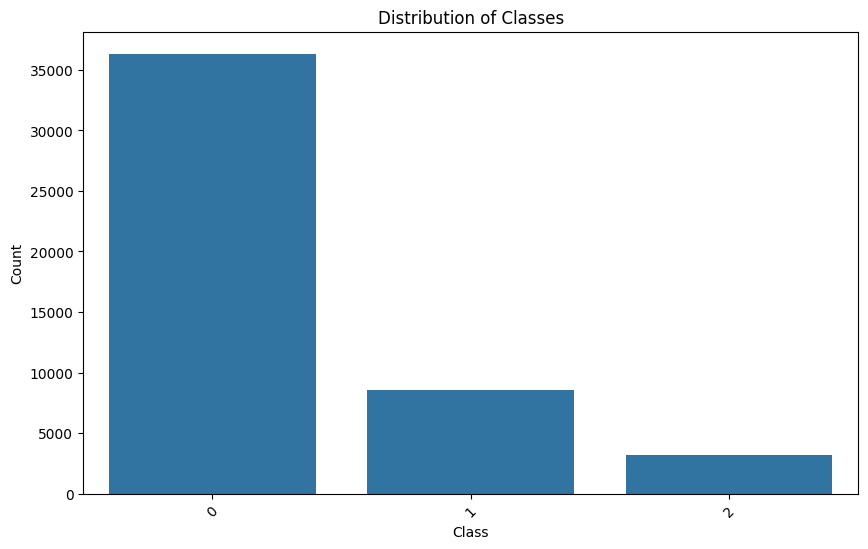

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Classes')
plt.ylabel('Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()

Get text length statistics

In [12]:
df['tweet_length'] = df['Tweet'].apply(len)
print(f"\nTweet length statistics:\n{df['tweet_length'].describe()}")


Tweet length statistics:
count    48076.000000
mean       114.664427
std         48.989974
min          5.000000
25%         83.000000
50%        115.000000
75%        139.000000
max        331.000000
Name: tweet_length, dtype: float64
